In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']) \
  .sort_values('reportts')

data = data[data['pos'] == 1]

y = data['egtm']

X = data.drop(columns=[
    'acnum', 'pos', 'dep', 'arr', 
    'egtm', 'fltdes', 'reportts',
    'dmusw', 'exswpn', 'reason'
]).fillna(0)

X = X.loc[:, ~X.columns.str.contains('stw')]

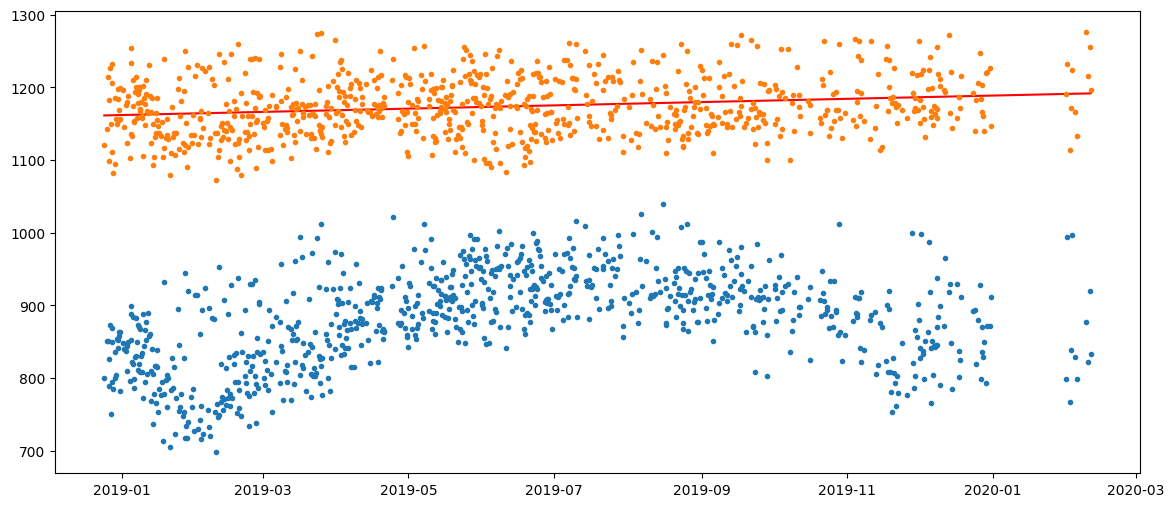

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
data['theta'] = (data['tat'] + 273.15) / 288.15

data['egtk'] = (data['egt'] + 273.15) / (data['theta'] ** 0.95)
z = np.polyfit(data['reportts'].astype(int) / 10**9, data['egtk'], 1)
p = np.poly1d(z)

ax.plot(data['reportts'], p(data['reportts'].astype(int) / 10**9), color='r')
ax.plot(data['reportts'], data['egt'], '.')
ax.plot(data['reportts'], data['egtk'], '.')
plt.show()

In [15]:
def cels_to_fahrenheit(series):
    return (series - 32) * (5.0/9.0)

In [25]:
(data['theta2'] ** 1)

0       0.890104
836     0.890104
1       0.905913
837     0.905913
2       0.872366
          ...   
833     0.857327
1670    0.885862
834     0.885862
835     0.871402
1671    0.871402
Name: theta2, Length: 1672, dtype: float64

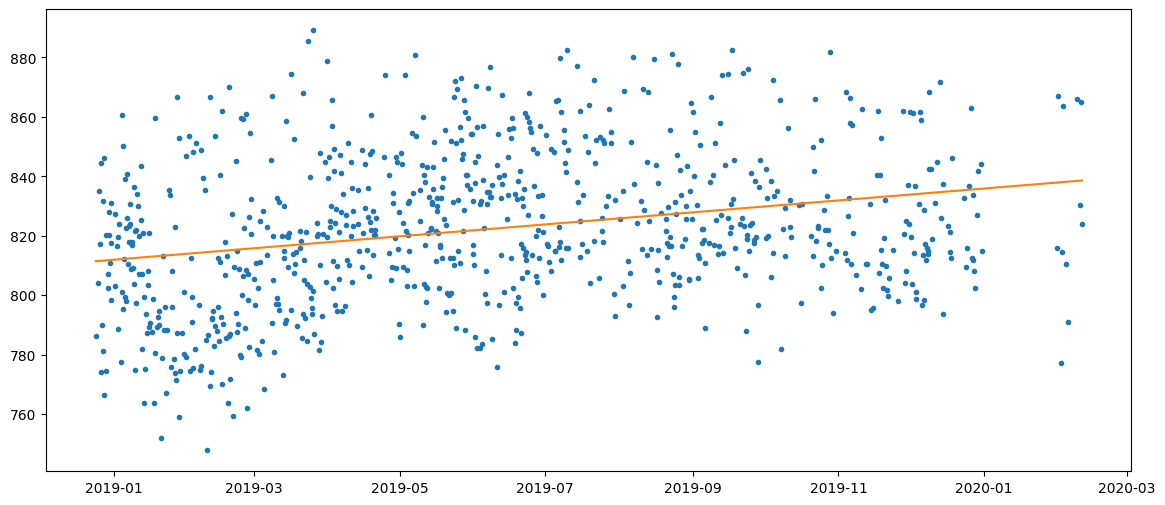

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

data['egtc'] = cels_to_fahrenheit(data['egt'])
data['tatc'] = cels_to_fahrenheit(data['tat'])

data['theta2'] = (data['tatc'] + 273.15) / 288.15

data['egtk'] = (data['egtc'] + 273.15) / (data['theta2'] ** 1)

z = np.polyfit(data['reportts'].astype(int) / 10**9, data['egtk'], 1)
p = np.poly1d(z)

# ax.plot(data['reportts'], data['egt'], '.')
ax.plot(data['reportts'], data['egtk'], '.')
ax.plot(data['reportts'], p(data['reportts'].astype(int) / 10**9))
plt.show()